In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from cdt.data import load_dataset
from scipy.stats import gamma, norm, lognorm
import os
import random


In [2]:
#Loads Tuebingen Dataset
def getnumpy(df):
    data=df.to_numpy()
    tables=[]
    for i in range(data.shape[0]):
        tables.append(np.array([data[i][0], data[i][1]]))
        
    return tables

def datasetTuebingen():
    t_data, t_labels = load_dataset('tuebingen')
    return getnumpy(t_data), t_labels.to_numpy()


t_data, t_target=datasetTuebingen()

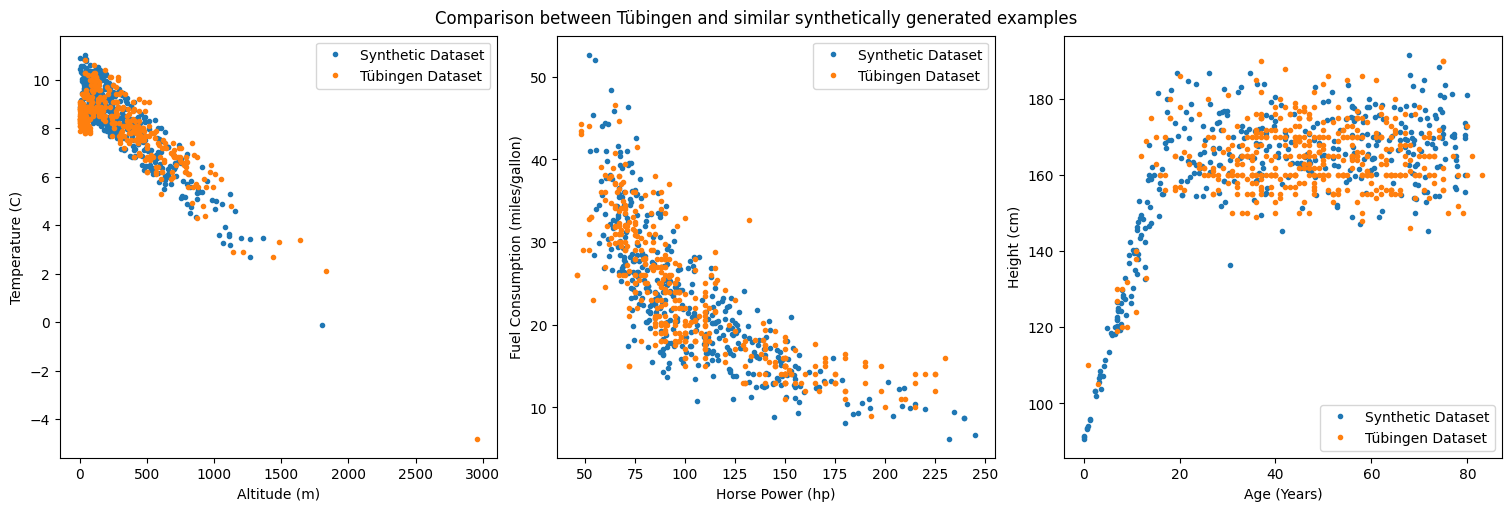

In [3]:
#Generate the plots in Figure 3.2: Comparison between Tubingen and synthetically generated examples

n = 400
eps=0.1

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

#Image Labels
x_titles=['Altitude (m)','Horse Power (hp)','Age (Years)']
y_titles=['Temperature (C)','Fuel Consumption (miles/gallon)','Height (cm)']
axs[0].set_xlabel(x_titles[0])
axs[0].set_ylabel(y_titles[0])
axs[1].set_xlabel(x_titles[1])
axs[1].set_ylabel(y_titles[1])
axs[2].set_xlabel(x_titles[2])
axs[2].set_ylabel(y_titles[2])

#Temperature(Altitude) Function
def prob_func_temp(x,psi):
    return -2.6/500*x+psi


data=np.zeros((2,n))
for i in range(n):
    theta = 125*np.random.chisquare(2.5) #prior on theta
    x=np.random.normal(theta,eps) #sample from p(x|theta)
    psi = np.random.uniform(8.8,11.2)    #prior on psi 
    y = np.random.normal(prob_func_temp(x,psi),eps) #sample from p(y|x,psi)
    data[:,i]=[theta,y] 

axs[0].plot(data[0],data[1],'.')

n = 400
eps=0.1


rng = np.random.default_rng()

#Fuel Consumption(Horse power) function
def prob_func_horse(x,psi):
    return psi/x

data=np.zeros((2,n))
for i in range(n):
    #various tested distribution for theta
    #theta = np.random.chisquare(0.1)
    #theta=boltzmann_sample = rng.boltzmann(1)
    #theta=np.random.lognormal(mean=0.5, sigma=0.5)
    #theta=np.random.choice(t_data[13][0])
    theta=225/4*gamma.rvs(a=2, scale=0.5)+50 #Prior on theta
    x=np.random.normal(theta,eps) #sample from p(x|theta)
    psi = 2143*np.random.normal(1,0.2)       #Prior on psi    
    y = np.random.normal(prob_func_horse(x,psi),eps)  #sample from p(y|theta,psi)
    data[:,i]=[theta,y]

axs[1].plot(data[0],data[1],'.')

#Height(Age) function
def prob_func(x,psi):
    s=90
    if x<20:
        return s+(psi-s)*x/17
    else:
        return psi

data=np.zeros((2,n))
for i in range(n):
    theta = np.random.uniform(0, 80) #prior on theta
    x=np.random.normal(theta,eps) #sample from p(x|theta)
    psi = np.random.normal(168, 9)   #prior on psi
    y = np.random.normal(prob_func(x,psi),eps) #compute y=p(y|theta,psi)
    data[:,i]=[theta,y]

axs[2].plot(data[0],data[1],'.')

#Plot graphs
axs[0].plot(t_data[0][0],t_data[0][1],'.')
axs[1].plot(t_data[13][0],t_data[13][1],'.')
axs[2].plot(t_data[21][0],t_data[21][1],'.')

axs[0].legend(['Synthetic Dataset','Tübingen Dataset'])
axs[1].legend(['Synthetic Dataset','Tübingen Dataset'])
axs[2].legend(['Synthetic Dataset','Tübingen Dataset'])

fig.suptitle("Comparison between Tübingen and similar synthetically generated examples")
plt.show()

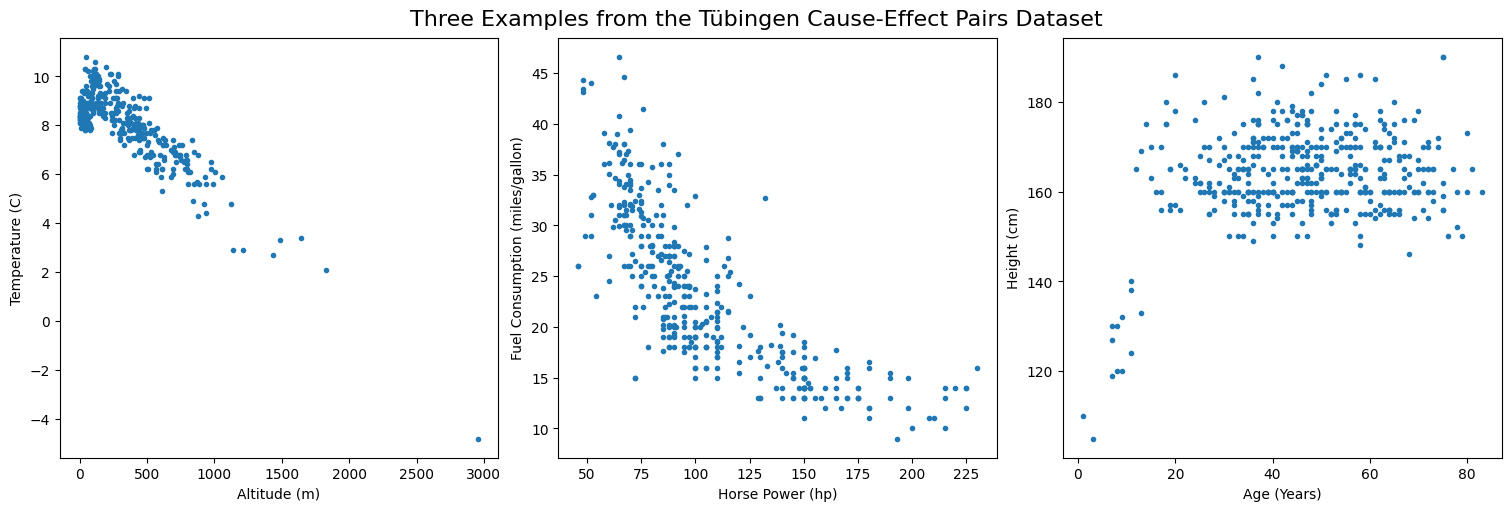

In [4]:
#Plot Figure 2.2: Tuebingen dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
x_titles=['Altitude (m)','Horse Power (hp)','Age (Years)']
y_titles=['Temperature (C)','Fuel Consumption (miles/gallon)','Height (cm)']
for i, (matrix, ax) in enumerate(zip([t_data[0], t_data[13], t_data[21]], axes)):
    ax.plot(matrix[0, :], matrix[1, :], '.')
    ax.set_xlabel(x_titles[i])
    ax.set_ylabel(y_titles[i])
fig.suptitle('Three Examples from the Tübingen Cause-Effect Pairs Dataset', fontsize=16)
plt.show()

In [76]:
#Create a folder with the Tuebingen dataset in your computer

def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

folder_name="tuebingen"
create_folder(folder_name)

for i in range(len(t_data)):
    # Create a new plot
    plt.figure()
    plt.plot(t_data[i][0], t_data[i][1],'.')  # Example plot
    
    # Save the plot as a PNG file in the folder
    plt.savefig(f"{folder_name}/plot_{i+1}.png")
    plt.close()  # Close the plot to avoid overlapping in next iteration

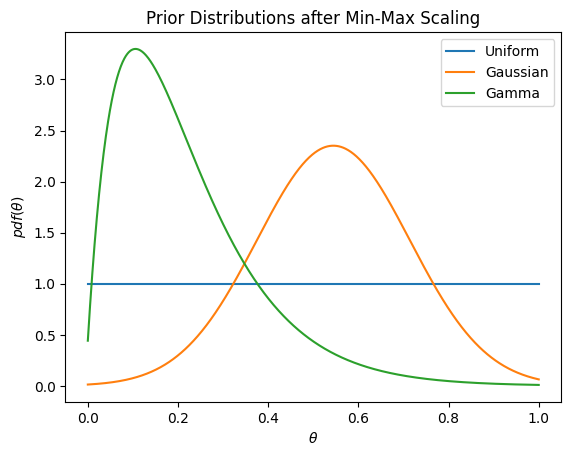

In [6]:
#Plot the different priors on theta and psi

#Create the linear space of samples (before normalization)
x=np.linspace(0,1,1000)
x2=np.linspace(0.358,1.537,1000)
x3=np.linspace(0.026,4.51,1000)
plt.figure()
plt.plot(x, np.ones_like(x) * (x >= 0) * (x <= 1)) #uniform distribution
plt.plot(x, (x2[-1]-x2[0])*norm.pdf(x2, 1, 0.2)) #gaussian distribution
plt.plot(x, (x3[-1]-x3[0])*gamma.pdf(x3, 2, scale=0.5)) #gamma distribution
plt.legend(['Uniform','Gaussian','Gamma'])
plt.title("Prior Distributions after Min-Max Scaling")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$pdf(\theta)$")
plt.show()

In [7]:
#Synthetic Database Generation Functions

#Min-max normalization
def minmax(data):
    return (data - data.min()) / (data.max() - data.min())

#linear function: Choose from 2x2 possible combinations:
#either m_0=1 and b_=0 or m_0=-1 and b=1
#either psi affects m or psi affects b (multiplicative or additive component)
def linear(theta,psi,rel_strength):
    if random.random()<0.5:
        m,b=[1,0]
        if random.random()<0.5:
            y = theta*m+rel_strength*(psi-np.mean(psi)*np.ones(psi.shape))+b*np.ones(psi.shape) #serves to normalize psi
        else:
            y = theta*(m*np.ones(psi.shape)+rel_strength*(psi-np.mean(psi)))+b*np.ones(psi.shape)
    else:
        m,b=[-1,1]
        if random.random()<0.5:
            y = theta*m+rel_strength*(psi-np.mean(psi)*np.ones(psi.shape))+b*np.ones(psi.shape) #serves to normalize psi
        else:
            y = theta*(m*np.ones(psi.shape)+rel_strength*(psi-np.mean(psi)*np.ones(psi.shape)))+b*np.ones(psi.shape)
    return y
    
#Piecewise linear function
def mix(theta,psi,rel_strength):
    splits=np.sort(np.random.uniform(0,1,size=np.random.choice([1,2,3,4,5]))) #sample how many pieces
    endpoints=np.random.uniform(0.2,5,size=len(splits)+2) #sample the length of each

    y=np.zeros(theta.shape)
    #each piece will vary between endpoints[j]*psi and endpoints[j+1]
    for i in range(len(theta)):
        flag=0
        for j in range(len(splits)):
            if theta[i]<splits[j] and flag==0:
                flag=1
                if j==0:
                    y[i]=rel_strength*psi[i]*endpoints[j]+rel_strength*psi[i]*(endpoints[j+1]-endpoints[j])*theta[i]/splits[j]
                else:
                    y[i]=rel_strength*psi[i]*endpoints[j]+rel_strength*psi[i]*(endpoints[j+1]-endpoints[j])*(theta[i]-splits[j-1])/(splits[j]-splits[j-1])
        if flag==0:
            y[i]=rel_strength*psi[i]*endpoints[-2]+rel_strength*psi[i]*(endpoints[-1]-endpoints[-2])*(theta[i]-splits[-1])/(1-splits[-1])
    return y
            
    
#Exponential function:
def exp(theta, psi,rel_strength):
    shift=np.random.uniform(0,1)
    sign=np.sign(np.random.normal(0,1))
    y=np.exp(sign*(theta+shift*sign*np.ones(psi.shape))*psi*rel_strength)
    return y

#Inversely proportional function
def inv(theta, psi,rel_strength):
    shift=np.random.uniform(0.05,1)
    sign=np.sign(np.random.normal(0,1))
    y=sign*rel_strength*psi/(theta+shift)
    return y

#Function to create a dataset.
def create_dataset(func,disttheta,distpsi,eps,N,samples):
    #gamma parameters
    a=2
    scale=0.5

    dir_name = f"generate_scenarios/exchangeable_{func}_{disttheta}_{distpsi}"
    os.makedirs(dir_name, exist_ok=True) 
    dir_name = f"allfigs"
    os.makedirs(dir_name, exist_ok=True) 

    for i in range(N):
        #prior on x (theta)
        if disttheta=="uni":
            theta=np.random.uniform(0,1,size=samples)
        elif disttheta=="normal":
            theta=np.random.normal(1,0.2,size=samples)
        elif disttheta=="twenty":
            theta=gamma.rvs(a=a, scale=scale,size=samples)

        #prior on psi
        if distpsi=="uni":
            psi=np.random.uniform(0,1,size=samples)
        elif distpsi=="normal":
            psi=np.random.normal(1,0.2,size=samples)
        elif distpsi=="twenty":
            psi=gamma.rvs(a=a, scale=scale,size=samples)

        #sampling relative strength
        rel_strength=np.random.uniform(0.5,2)

        #Normalization using min-max
        theta=minmax(theta)
        psi=minmax(psi)
        theta=np.sort(theta)

        #Sample x from p(x|theta)
        x=minmax(np.random.normal(theta,eps,size=samples)) 

        #func
        if func=="linear":
            ymed=linear(x,psi,rel_strength)
        elif func=="exp":
            ymed=exp(x,psi,rel_strength)
        elif func=="inv":
            ymed=inv(x,psi,rel_strength)
        elif func=="mix":
            ymed=mix(x,psi,rel_strength)

        y=minmax(np.random.normal(ymed,eps,size=samples))        

        plt.figure()
        plt.plot(x, y,'.')  # Example plot
        plt.xlabel("X")
        plt.ylabel("Y")
        # Save the plot as a PNG file in the folder
        plt.savefig(f"generate_scenarios/exchangeable_{func}_{disttheta}_{distpsi}/plot_{i+1}.png")
        plt.savefig(f"allfigs/exchangeable_{func}_{disttheta}_{distpsi}_plot_{i+1}.png")
        plt.close()  # Close the plot to avoid overlapping in next iteration

In [33]:
#Generates the datasets
samples=400
N=20
eps=0.02

distthetas=["uni","normal","twenty"]
distpsis=["uni","normal","twenty"]
funcs=["linear","exp","inv","mix"]
for func in funcs:
    for disttheta in distthetas:
        for distpsi in distpsis:
            create_dataset(func,disttheta,distpsi,eps,N,samples)

The figure layout has changed to tight


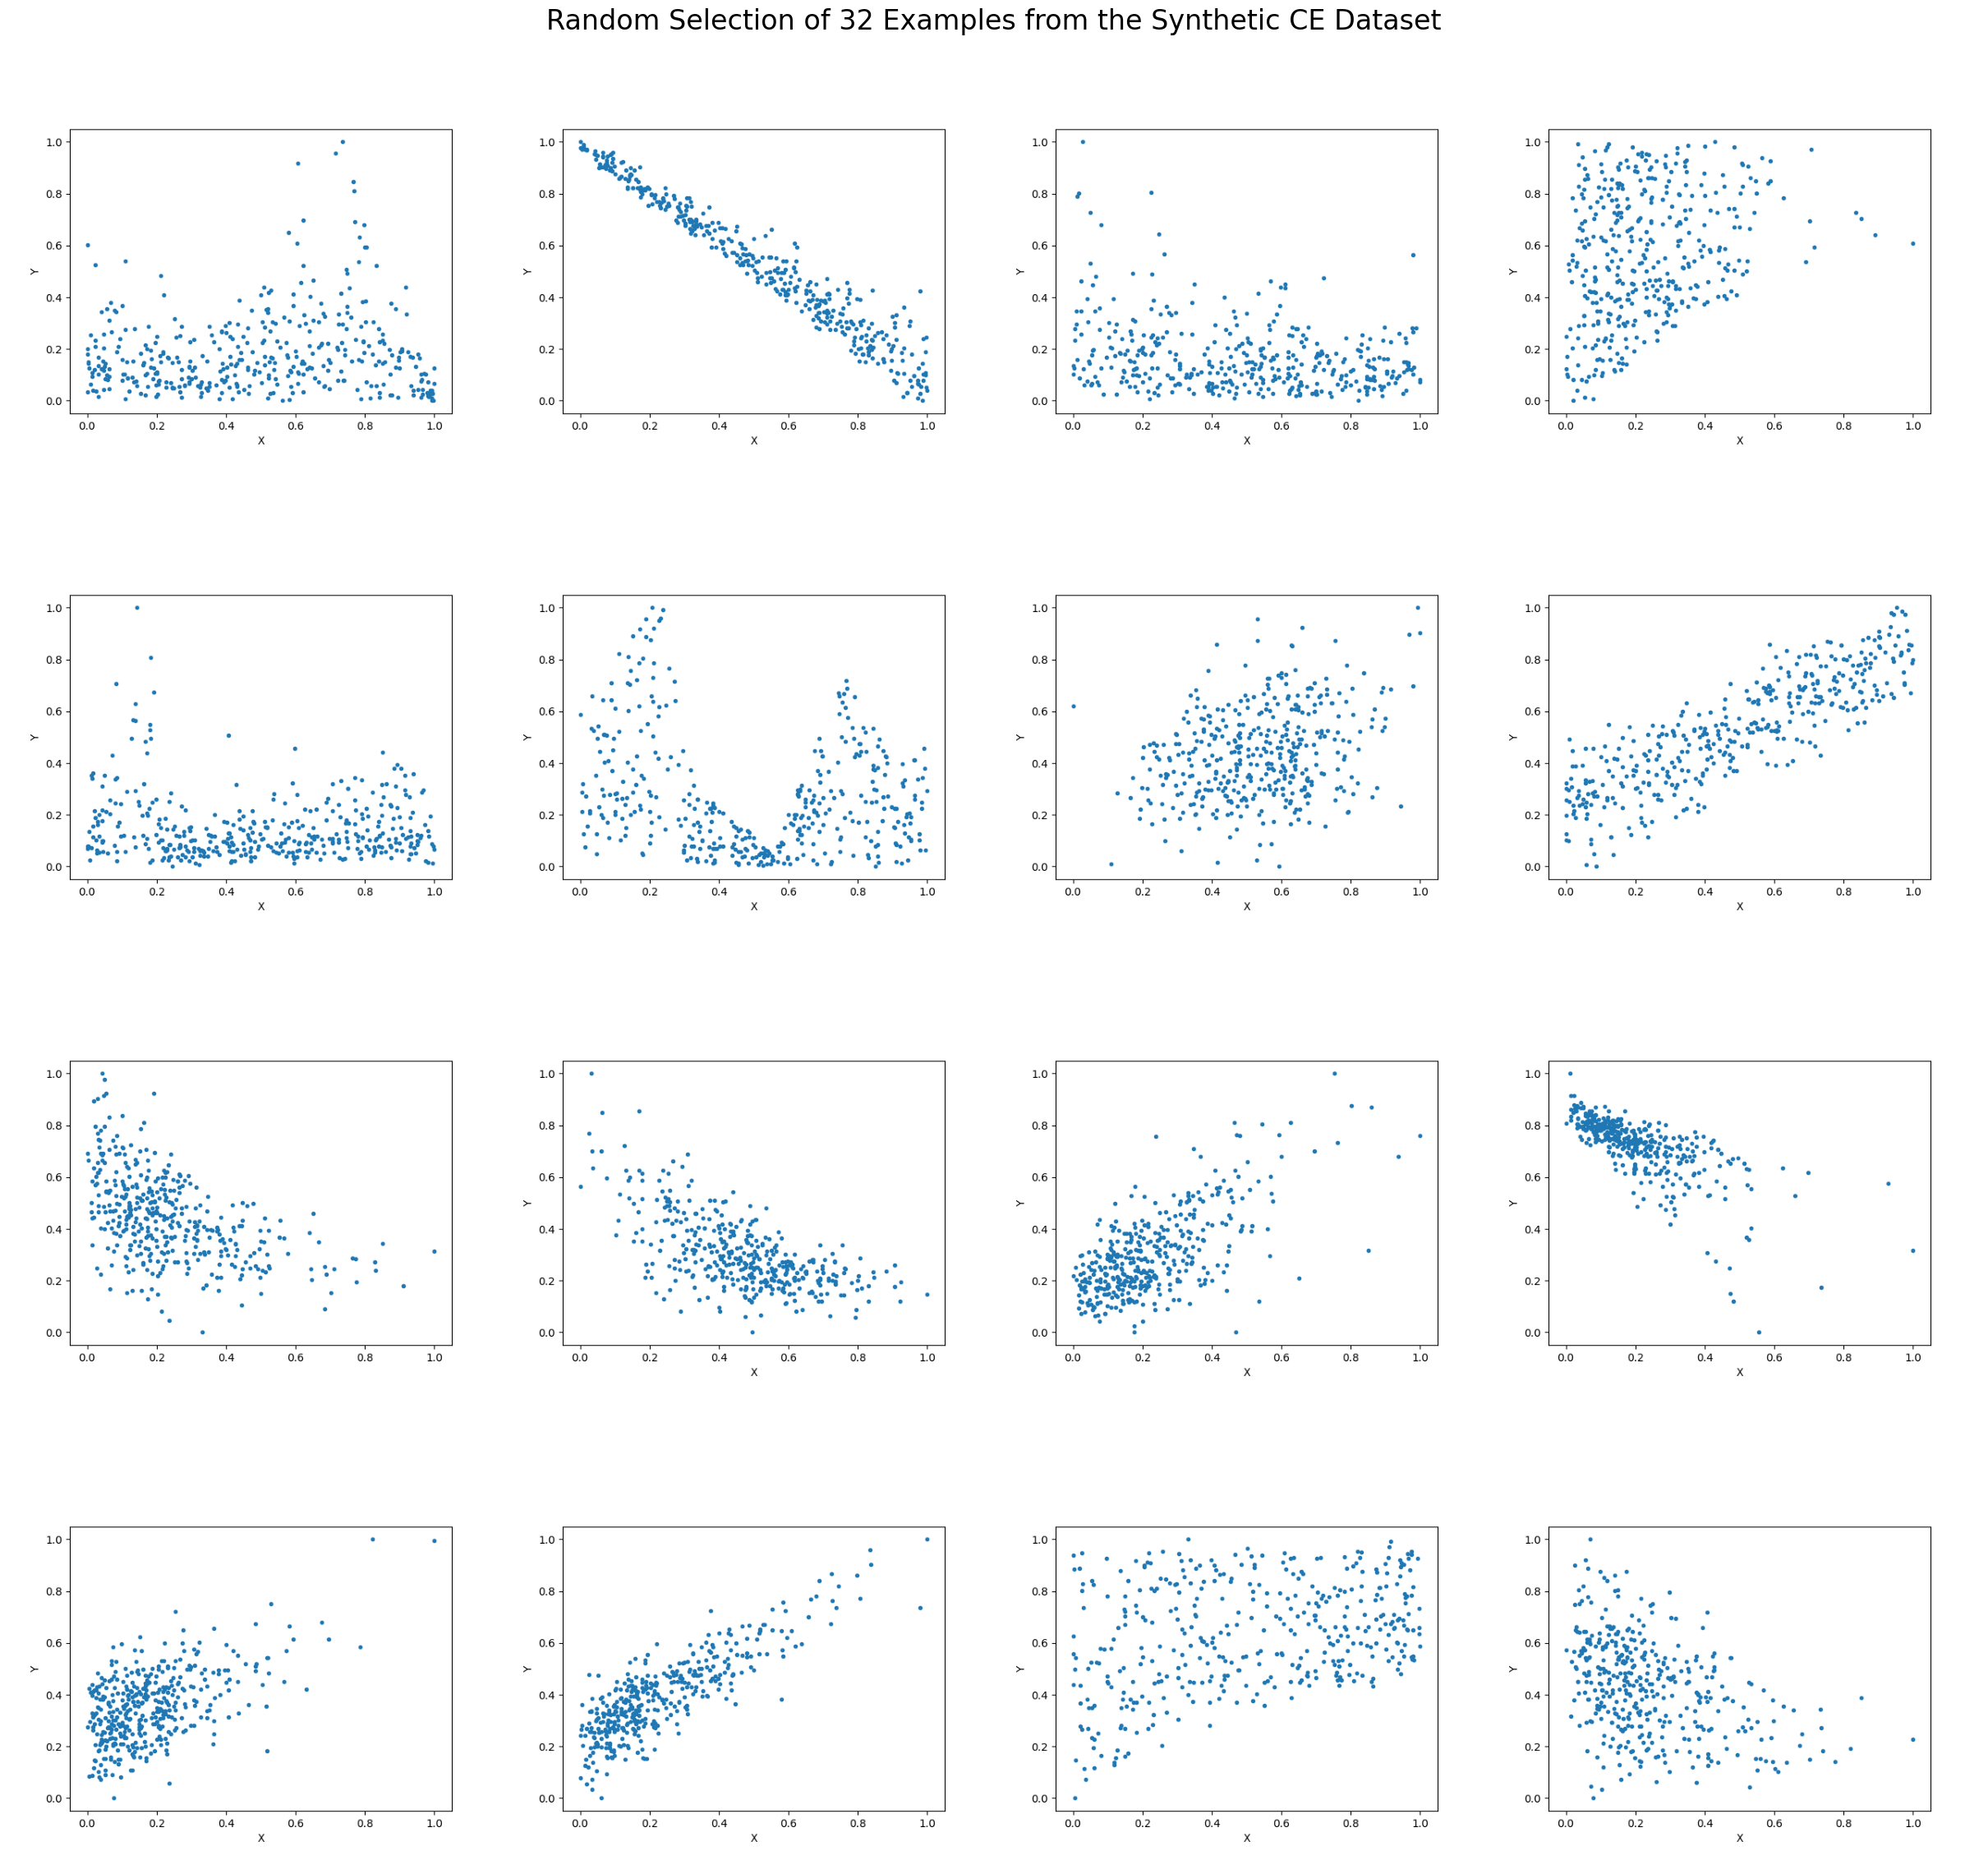

In [88]:
#Obtain the synthetic dataset from the folder, load it and plot it
import matplotlib.image as mpimg

# Path to the folder containing images
folder_path = 'allfigs'

# Get a list of all files in the folder
all_files = os.listdir(folder_path)

# Filter out non-image files (optional, assuming files are jpg/png etc.)
image_files = [file for file in all_files if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]

# Select 32 random images
selected_images = random.sample(image_files, 16)

# Set up the plot with 8 rows and 4 columns, and reduce spacing
fig, axes = plt.subplots(4, 4, figsize=(24, 24), constrained_layout=True)

# Loop over the axes and selected images to display them
for i, ax in enumerate(axes.flat):
    # Load and display each image
    img_path = os.path.join(folder_path, selected_images[i])
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # Turn off axis labels
    ax.set_aspect('equal')

# Adjust spacing to reduce gaps between images

fig.suptitle('Random Selection of 32 Examples from the Synthetic CE Dataset', fontsize=24)
# Display the grid
plt.tight_layout(pad=0.0)  # Remove padding
plt.show()
